In [12]:
%matplotlib inline
from pylab import *

from Orbit_Simulator import Orbit_Simulator

#HIP = 16537 #epsilon Eridani, dropped due to high zodi
#HIP = 8102   #tau Ceti
#HIP = 37279  #Procyon A
#HIP = 108870 #epsilon Indi A
#HIP = 32349  #Sirius A
#HIP = 19849  #omicron 2 Eridani
#HIP = 97649  #Altair
#HIP = 99240  #delta Pavonis
#HIP = 15510  #82 Eridani
HIP = 96100  #sigma Draconis
#HIP = 2021  #beta Hyi
#HIP = 61317  #beta CVn
#HIP = 22449  #1 Ori
##HIP = 91262 #Vega, dropped due to high zodi
##HIP = 86974 #Mu Herculis, dropped to binary companion contamination
#HIP = 113368 #Fomalhaut
#HIP = 17378  #Delta Eridani
#HIP = 27072  #Gamma Leporis
#HIP = 1599   #Zeta Tucanae
    
OrbSim = Orbit_Simulator(HIP)


Initializing Orbit_Simulator
sigma Draconis


Time Windows (2):  [[70, 151], [435, 516]]
Window Durations (days):  [81, 81]
Observation Times:  [ 70 110 435 475]


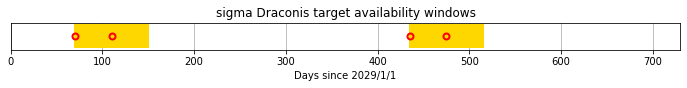

In [13]:
'''
Plot the target availability windows
'''
OrbSim.get_observation_time_array(init_date = '2029/1/1',
                                  duration_yrs=2)

figure(1, figsize=(12,0.5))
col='k'
plot(OrbSim.days[OrbSim.obs_cut], np.ones(len(OrbSim.days[OrbSim.obs_cut])), 
     '|', mew=2, ms=24, color='gold')
xlabel('Days since %s'%OrbSim.init_date)
xlim(0,len(OrbSim.ang))
yticks([])
grid(True)
title(OrbSim.star_name+ ' target availability windows')

plot(OrbSim.t_obs_array, 1.*np.ones(len(OrbSim.t_obs_array)), 
     'ro', ms=6, mfc='none', mec='r', mew=2)


In [14]:
hits = 0
while hits<3:
    OrbSim.sample_orbits(num_samples=1)
    entry = np.random.randint(len(OrbSim.Period))
    hits = OrbSim.hits[entry]
print('entry:', entry)
print('Number of Detections', OrbSim.hits[entry])
true_dat   = np.array([OrbSim.projected_x_mas[:,entry], OrbSim.projected_y_mas[:,entry]])
SNR        = OrbSim.SNR[:, entry]

# Generate simulated astrometric data with uncertainties
err_data   = np.array([65./SNR,65./SNR]) 
dat        = true_dat + np.random.normal(0.,err_data)
data = np.zeros((2,(OrbSim.hits[entry])))
data_uncertainties= np.zeros((2,(OrbSim.hits[entry])))
time = np.zeros((OrbSim.hits[entry]))

print('SNR',SNR)
print('astrometric uncertainty',65./SNR)
count=0
for ii in range(0,len(SNR)):
    if SNR[ii]>OrbSim.SNR_cut:
        data[:,count] = dat[:,ii]
        data_uncertainties[:,count] = err_data[:,ii]
        time[count] = OrbSim.t_obs_array[ii]
        count+=1

entry: 0
Number of Detections 4
SNR [11.18921353  9.49987148  8.51062567 10.84949572]
astrometric uncertainty [5.80916611 6.84219783 7.63751133 5.99106186]


/Users/romerowo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


" \nsavefig('orbit_example_1.pdf')\n"

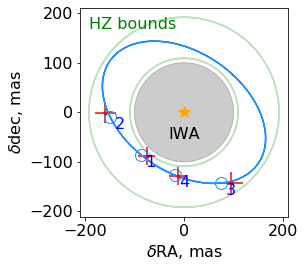

In [15]:
from Kepler import Kepler
KPC = Kepler(force_new_LUT=False)

truth_parameters = np.array([OrbSim.a_SM[entry], 
                             OrbSim.t_0[entry], 
                             OrbSim.star_model.Mass, 
                             OrbSim.eccentricity[entry], 
                             OrbSim.LAN[entry], 
                             OrbSim.inclination[entry], 
                             OrbSim.arg_peri[entry], 
                             OrbSim.star_model.d_pc])

truth_Kepler_parameters = np.array([OrbSim.a_SM[entry], 
                                    OrbSim.t_0[entry], 
                                    OrbSim.Period[entry], 
                                    OrbSim.eccentricity[entry], 
                                    OrbSim.LAN[entry], 
                                    OrbSim.inclination[entry], 
                                    OrbSim.arg_peri[entry]])


'''
Plot data
'''
rcParams['font.size']=16
figure(1, figsize=(4.5,4))
ax=subplot(111)
dt = OrbSim.Period/2000.
t_val = np.arange(0.,2.*OrbSim.Period, dt)

''' 
Plot the true orbit on the sky 
'''
pts_s = KPC.get_Orbit_points(t_val, *truth_Kepler_parameters)
plot(pts_s[0], pts_s[1], '-', color='dodgerblue')

''' 
Plot the inner and outer habitable zone bounds 
projected on the sky 
'''
prm = truth_Kepler_parameters.copy()
prm[0] = OrbSim.HZ_mas[0]
prm[-2] = 0.
pts_In = KPC.get_Orbit_points(t_val, *prm)
plot(pts_In[0], pts_In[1], 'g-', alpha=0.25)
prm[0] = OrbSim.HZ_mas[1]
pts_Out = KPC.get_Orbit_points(t_val, *prm)
plot(pts_Out[0], pts_Out[1], 'g-', alpha=0.25)

'''
Get bounds for plotting
'''
abs_max = np.max([np.max(np.abs(pts_s[0])), 
                  np.max(np.abs(pts_s[1])),
                  np.max(np.abs(pts_Out[0])),
                  np.max(np.abs(pts_Out[1]))])


'''
Plot true planet positions during observation times
'''
pts_0 = KPC.get_Orbit_points(OrbSim.t_obs_array, *truth_Kepler_parameters)
plot(pts_0[0], pts_0[1], 'o', mfc='none', mec='dodgerblue', ms=12)

'''
Label the observation number
'''
for k in range(len(OrbSim.t_obs_array)):
    text(pts_0[0,k], pts_0[1,k], ' %d'%(k+1), verticalalignment='top', color='blue')

'''
Plot the simulated data with error bars
'''
errorbar(data[0], data[1], xerr = 3.*data_uncertainties[0], yerr=3.*data_uncertainties[1], fmt='r.')

'''
Mark the position of the star
'''
plot([0.], [0.], '*', ms=12, color='orange')

# print 'data[0]', data[0]
# print 'data[1]', data[1]
# print 'time_array', time_array

'''
Draw the size of the inner working angle
'''
circle1 = plt.Circle((0., 0.), 100., color='k', alpha=0.2)
ax.add_artist(circle1)
text(0., -30., 'IWA', color='k', verticalalignment='top', horizontalalignment='center')
#xlim(-fl['HZ_mas'][1], fl['HZ_mas'][1])
#ylim(-fl['HZ_mas'][1], fl['HZ_mas'][1])
text(-abs_max, abs_max, 'HZ bounds', color='g', verticalalignment='top')
abs_max *= 1.1
xlim(-abs_max, abs_max)
ylim(-abs_max, abs_max)

xlabel('$\delta$RA, mas')
ylabel('$\delta$dec, mas')
tight_layout()
axes().set_aspect('equal', 'datalim')
''' 
savefig('orbit_example_1.pdf')
'''


In [16]:
print('OrbSim.a_SM', OrbSim.a_SM)
print('\n\n')
print('truth_parameters', truth_parameters)

OrbSim.a_SM [181.88331898]



truth_parameters [181.88331898 288.4893349    0.803        0.           4.58167133
   2.29837467   3.74608697   5.75407101]


In [17]:
'''
Initialize Inference
'''

from Orbit_Fitter import Orbit_emcee
'''
Set upper bounds on period and semimajor axisfor the emcee fit
'''
Period_max_val = 2.*OrbSim.Period
a_SM_max_val = 2.*OrbSim.HZ_mas[1]
print('a_SM_max_val', a_SM_max_val)
print('Period_max_val', Period_max_val)
print('\n\n')

OE = Orbit_emcee(KPC, # an instance of the UHE_fluence calculator class
                 time, data, data_uncertainties,
                 initial_parm_vals = truth_parameters,
                 ndim = 8,
                 nwalkers = 100, # ndim * 10
                 niterations = 5000, # number of steps in mcmc sampler
                 interval = 1000, # the interval over which we save the data.
                 out_tag = '',
                 out_dir = './',
                 a_SM_min=0.,
                 a_SM_max=a_SM_max_val,
                 t_0_min=0.,
                 t_0_max=Period_max_val,
                 star_mass_Msun = OrbSim.star_model.Mass,
                 star_mass_Msun_fractional_uncertainty=0.1,
                 #Period_min = 0.,
                 #Period_max = Period_max_val,
                 eccentricity_min = 0.,
                 eccentricity_max = 1.,
                 LAN_min = 0.,
                 LAN_max = 3.*pi,
                 inclination_min = 0.,
                 inclination_max = 2.*pi,
                 arg_peri_min = 0.,
                 arg_peri_max = 2.*pi,
                 distance_to_star_pc = OrbSim.star_model.d_pc,
                 distance_to_star_pc_fractional_uncertainty=0.01
                )

a_SM_max_val 383.3816252634897
Period_max_val [872.83870364]



Initializing Orbit_likelihood
1000 5 5000 5000
N= 0 of 4


/Users/romerowo/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


	Mean acceptance fraction: 3.10e-01
N= 1 of 4
	Mean acceptance fraction: 2.68e-01
N= 2 of 4
	Mean acceptance fraction: 2.57e-01
N= 3 of 4
	Mean acceptance fraction: 2.54e-01
N= 4 of 4
	Mean acceptance fraction: 2.54e-01


(100, 5000, 8)
100


Text(0, 0.5, '$a_{SM}$, mas')

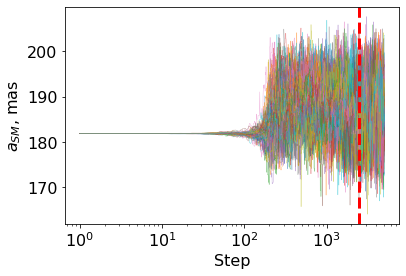

In [18]:
'''
Check for convergence
'''

'''
Take out half the samples to make sure the fitter has more than enough burn time.
'''
chain_offset = len(OE.chain[0, :, 0])//2
ndim = len(truth_parameters)

'''
Plot the chain to make sure there aren't strange outliers.
Steps to the left of the red dashed line are cut out to allow for burn in time.
Steps to the right should show that the sampler has had sufficient burn-in time. 
'''
print(OE.chain.shape)
print(len(OE.chain[:,0,0]))
for k in range(len(OE.chain[:,0,0])):
    semilogx(range(1,len(OE.chain[0,:,0])+1),  OE.chain[k,:,0], ms=1, lw=0.5, alpha=0.5)
y1, y2 = ylim()
plot([chain_offset, chain_offset], [y1, y2], 'r--', lw=3)
ylim(y1, y2)
xlabel('Step')
ylabel('$a_{SM}$, mas')


Probability this planet is not in the habitable zone:
p = 1.92e-01


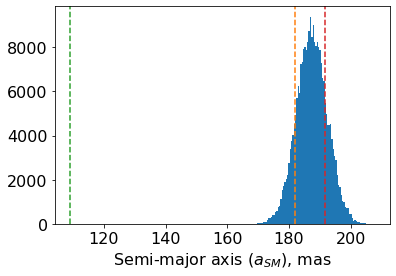

In [19]:
'''
Compare the semi-major axis to the habitable zone bounds. 
'''

'''
extract samples
'''

samples  = OE.chain[:, chain_offset:, :].reshape((-1, ndim))
a_SM     = samples[:,0] 
T_0      = samples[:,1] 
M_star   = samples[:,2] 
ecc      = samples[:,3] 
Omega    = samples[:,4] 
inc      = samples[:,5] 
sm_omega = samples[:,6] 
d_star   = samples[:,7] 

'''
Plot the distribution of the semi-major axis 
compared to the habitable zone inner and outer bounds. 
'''
figure()
hist(a_SM, bins=100)
y1, y2 = ylim()
plot([OrbSim.a_SM[0], OrbSim.a_SM[0]], [y1, y2], '--')
plot([OrbSim.HZ_mas[0], OrbSim.HZ_mas[0]], [y1, y2], '--')
plot([OrbSim.HZ_mas[1], OrbSim.HZ_mas[1]], [y1, y2], '--')
ylim(y1, y2)
xlabel('Semi-major axis ($a_{SM}$), mas')

'''
Estimate the number of samples outside the habitable zone bounds
'''
cut = np.logical_or(a_SM<OrbSim.HZ_mas[0], a_SM>OrbSim.HZ_mas[1]) 

print('Probability this planet is not in the habitable zone:')
if np.sum(cut)==0:
    print('p < %1.2e'%(1./float(len(a_SM))))
else:
    print('p = %1.2e'%(float(np.sum(cut))/float(len(a_SM))))

Text(0.5, 0, 'Orbital Period, years')

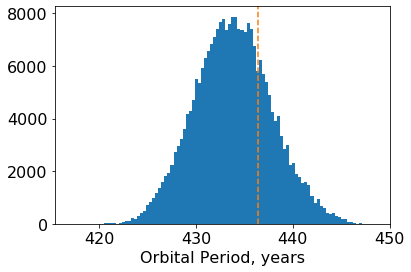

In [20]:
'''
Plot the distribution of the orbital period
'''

mAU_in_meters  = 1.49598e+8 # 1 AU is 1.49597e+11 meters. When convertain mas * pc = mAU = 10^-3 AU.
G_Newton       = 6.67408e-11 # m3 kg-1 s-2
Msun_in_kg     = 1.989e30 #kg
day_in_seconds = 24.*60.**2 # 1 day in seconds.

def Period(a_in_mas, d_pc, Mass_in_Msun):
    a_in_meters = a_in_mas * d_pc * mAU_in_meters
    Mass_in_kg = Mass_in_Msun * Msun_in_kg
    Period_in_seconds = 2.*pi * np.sqrt( a_in_meters**3 / ( G_Newton * Mass_in_kg) )
    Period_in_days = Period_in_seconds / day_in_seconds
    return Period_in_days
    
    
period = Period(a_SM, d_star, M_star)
figure()
hist(period, bins=100)
y1, y2 = ylim()
plot([OrbSim.Period, OrbSim.Period], [y1, y2], '--')
ylim(y1, y2)
xlabel('Orbital Period, years')

(100, 5000, 8)
(250000, 8)
[181.88331898 288.4893349    0.803        0.           4.58167133
   2.29837467   3.74608697   5.75407101]


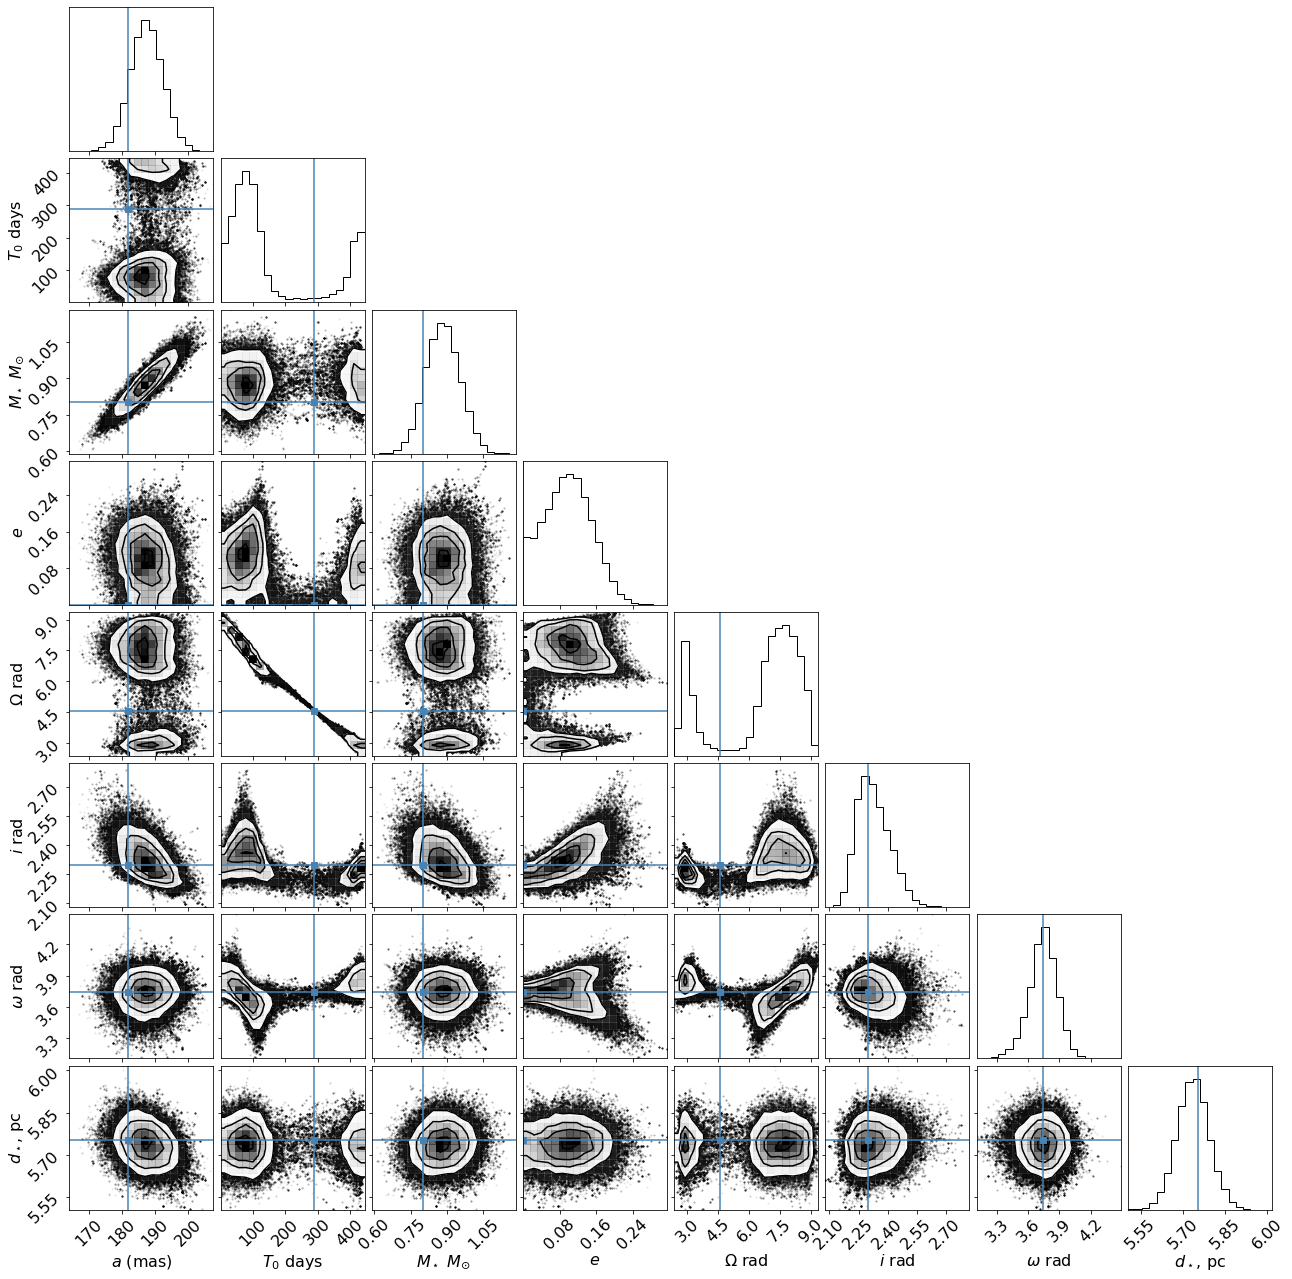

In [21]:
'''
Corner plot of the posterior distributions
'''

import corner
samples = OE.chain[:, chain_offset:, :].reshape((-1, ndim))
print(OE.chain.shape) #walkers, iterations, shape
print(samples.shape)
labels = ['$a$ (mas)', '$T_0$ days', '$M_\star$ $M_{\odot}$', '$e$', 
          '$\Omega$ rad', '$i$ rad', '$\omega$ rad', '$d_\star$, pc']
fig = corner.corner(samples, labels=labels,
                      truths=truth_parameters)
fig.savefig("triangle.png")
print(truth_parameters)

In [ ]:
'''
from Kepler import Kepler
KPC = Kepler(force_new_LUT=False)

truth_parameters = np.array([OrbSim.a_SM[entry], 
                             OrbSim.t_0[entry], 
                             OrbSim.star_model.Mass, 
                             OrbSim.eccentricity[entry], 
                             OrbSim.LAN[entry], 
                             OrbSim.inclination[entry], 
                             OrbSim.arg_peri[entry], 
                             OrbSim.star_model.d_pc])

truth_Kepler_parameters = np.array([OrbSim.a_SM[entry], 
                                    OrbSim.t_0[entry], 
                                    OrbSim.Period[entry], 
                                    OrbSim.eccentricity[entry], 
                                    OrbSim.LAN[entry], 
                                    OrbSim.inclination[entry], 
                                    OrbSim.arg_peri[entry]])

'''

'''
Plot data
'''
rcParams['font.size']=16
figure(1, figsize=(4.5,4))
ax=subplot(111)
dt = OrbSim.Period/2000.
t_val = np.arange(0.,2.*OrbSim.Period, dt)

'''
Plot fitted orbits
'''
for k in range(0,100):
    rand_entry = np.random.randint(0,len(a_SM))
    sampled_Kepler_parameters = np.array([a_SM[rand_entry],
                                          T_0[rand_entry],
                                          period[rand_entry],
                                          ecc[rand_entry],
                                          Omega[rand_entry],
                                          inc[rand_entry],
                                          sm_omega[rand_entry]])
    #print(truth_Kepler_parameters, sampled_Kepler_parameters)
    pts_s = KPC.get_Orbit_points(t_val, *sampled_Kepler_parameters)
    plot(pts_s[0], pts_s[1], '-', color='k', lw=0.1, alpha=1.)

''' 
Plot the true orbit on the sky 
'''
pts_s = KPC.get_Orbit_points(t_val, *truth_Kepler_parameters)
plot(pts_s[0], pts_s[1], '-', color='orange')


''' 
Plot the inner and outer habitable zone bounds 
projected on the sky 
'''
prm = truth_Kepler_parameters.copy()
prm[0] = OrbSim.HZ_mas[0]
prm[-2] = 0.
pts_In = KPC.get_Orbit_points(t_val, *prm)
plot(pts_In[0], pts_In[1], '-', color='limegreen', alpha=1.)
prm[0] = OrbSim.HZ_mas[1]
pts_Out = KPC.get_Orbit_points(t_val, *prm)
plot(pts_Out[0], pts_Out[1], '-', color='limegreen', alpha=1.)

'''
Get bounds for plotting
'''
abs_max = np.max([np.max(np.abs(pts_s[0])), 
                  np.max(np.abs(pts_s[1])),
                  np.max(np.abs(pts_Out[0])),
                  np.max(np.abs(pts_Out[1]))])


'''
Plot true planet positions during observation times
'''
pts_0 = KPC.get_Orbit_points(OrbSim.t_obs_array, *truth_Kepler_parameters)
plot(pts_0[0], pts_0[1], 'o', mfc='none', mec='orange', ms=12)

'''
Label the observation number
'''
for k in range(len(OrbSim.t_obs_array)):
    text(pts_0[0,k], pts_0[1,k], ' %d'%(k+1), verticalalignment='top', color='blue')

'''
Plot the simulated data with error bars
'''
errorbar(data[0], data[1], xerr = 3.*data_uncertainties[0], yerr=3.*data_uncertainties[1], fmt='r.')

'''
Mark the position of the star
'''
plot([0.], [0.], '*', ms=12, color='orange')

# print 'data[0]', data[0]
# print 'data[1]', data[1]
# print 'time_array', time_array

'''
Draw the size of the inner working angle
'''
circle1 = plt.Circle((0., 0.), 100., color='k', alpha=0.2)
ax.add_artist(circle1)
text(0., -30., 'IWA', color='k', verticalalignment='top', horizontalalignment='center')
#xlim(-fl['HZ_mas'][1], fl['HZ_mas'][1])
#ylim(-fl['HZ_mas'][1], fl['HZ_mas'][1])
text(-abs_max, abs_max, 'HZ bounds', color='g', verticalalignment='top')
abs_max *= 1.1
xlim(-abs_max, abs_max)
ylim(-abs_max, abs_max)

xlabel('$\delta$RA, mas')
ylabel('$\delta$dec, mas')
tight_layout()
axes().set_aspect('equal', 'datalim')
''' 
savefig('orbit_example_1.pdf')
'''
